In [1]:
"""Generate network buffers around count locations using osmnx and networkx
author: Joe Broach <jbroach@pdx.edu> 
created: May 19, 2021

TODO : consider speeding up by splitting into parallel processes

"""

'Generate network buffers around count locations using osmnx and networkx\nauthor: Joe Broach <jbroach@pdx.edu> \ncreated: May 19, 2021\n\nTODO : consider speeding up by splitting into parallel processes\n\n'

In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
#import matplotlib.pyplot as plt  ## not needed
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import csv
import pandas as pd
from time import time

In [3]:
### Modify run params here ###
# load count locations
location = "Portland"
local_sites_file = "F:/Bike Fusion/New Plan/Circular Automatic Collected data for modeling/Portland/Bike Fusion/sites_all_study_area.csv"
region_boundaries_url = "http://web.pdx.edu/~jbroach/bike-data-fusion/study_area_boundaries.geojson"
outfile_dir = "F:/Bike Fusion/New Plan/Circular Automatic Collected data for modeling/Portland/Bike Fusion" # no trailing slash
counter_types = set(['permanent', 'short-term'])  ## e.g. 'permanent', 'short-term'  
buffer_dists_mi = ['0.1','0.25','0.5','0.75','1.0', '1.5', '2.0']  # in mi
undirected = True   # if True, networkx will solve both inbound & outbound from count site
                    # this is about 3x slower but a better measure where one-ways significant
save_osm = False  # if True, save out a static OSM file to outfile_dir 

In [4]:
# convert distances to m
k = 1609.34  # mi to m
buffer_dists = [float(d) * k for d in buffer_dists_mi]
buffer_dists

[160.934,
 402.335,
 804.67,
 1207.0049999999999,
 1609.34,
 2414.0099999999998,
 3218.68]

In [5]:
with open(local_sites_file, encoding='utf-8-sig') as f:
    reader = csv.DictReader(f)
    site_points = [row for row in reader if row['region'] == location and 
                  row['sensor_type'] in counter_types]  
print('{} sites found like...'.format(len(site_points)))
site_points[:2]

199 sites found like...


[{'site_id': 'P001POR',
  'site_name': 'HAWTHORNE BR north side',
  'region': 'Portland',
  'sensor_type': 'permanent',
  'latitude': '45.51383',
  'longitude': '-122.67284',
  'strava_id': '857907',
  'osm_id_sensor': '681301893',
  'comment': '',
  'in_2019': '1',
  'in_2018': '1',
  'in_2017': '1',
  'in_2018_or_2019': '1'},
 {'site_id': 'P002POR',
  'site_name': 'HAWTHORNE BR south side',
  'region': 'Portland',
  'sensor_type': 'permanent',
  'latitude': '45.513187',
  'longitude': '-122.67121',
  'strava_id': '860881',
  'osm_id_sensor': '689032191',
  'comment': '',
  'in_2019': '1',
  'in_2018': '1',
  'in_2017': '1',
  'in_2018_or_2019': '1'}]

   fid     region comment  epsg_local  \
0    1    Boulder    None        2772   
1    2     Eugene    None        2839   
2    3       Bend    None        2839   
3    4  Charlotte    None        3358   
4    5     Dallas    None        2845   

                                            geometry  
0  MULTIPOLYGON (((-105.64858 40.06198, -105.6480...  
1  MULTIPOLYGON (((-123.73473 43.94406, -123.7392...  
2  MULTIPOLYGON (((-121.40550 44.39315, -121.4025...  
3  MULTIPOLYGON (((-80.74046 35.37771, -80.73779 ...  
4  MULTIPOLYGON (((-96.52941 32.54528, -96.52964 ...  
AxesSubplot(0.125,0.277657;0.775x0.449685)
local srid = 2838


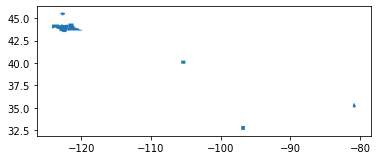

In [6]:
# Read region boundaries from master file
polybound = gpd.read_file(region_boundaries_url)
print(polybound.head())
print(polybound.plot())

# select regional boundary and transform to local coords for buffering
local_poly = polybound[polybound['region'] == location]
local_srid = int(local_poly['epsg_local'])
print('local srid = {}'.format(local_srid))

AxesSubplot(0.125,0.127085;0.775x0.75083)
AxesSubplot(0.147591,0.125;0.729818x0.755)


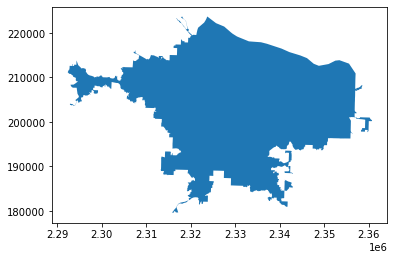

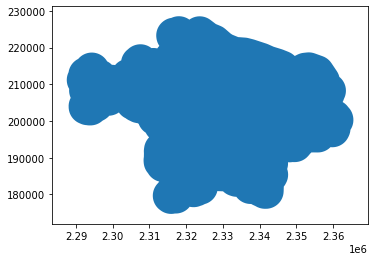

In [7]:
local_poly = local_poly.to_crs(local_srid)
print(local_poly.plot())

three_miles = 1609.34 * 3 # 3 miles in meters  TODO : make this smarter
poly_buff = local_poly.buffer(three_miles)
print(poly_buff.plot())

# convert to unprojected polygon for osmnx data pull
polygon = poly_buff.to_crs(4326).iloc[0]
#polygon

In [8]:
print('Pulling OSM network...')
t1 = time()
# Pull the network for region boundary
G = ox.graph_from_polygon(polygon, network_type='bike', simplify=True)
print('...completed in {:.2f} minutes'.format((time() - t1) / 60))

Pulling OSM network...
...completed in 4.23 minutes


In [9]:
print('Projecting OSM network...')
t1 = time()
G_proj = ox.projection.project_graph(G, to_crs=local_srid)
print('...completed in {:.2f} minutes'.format((time() - t1) / 60))

Projecting OSM network...
...completed in 1.33 minutes


In [10]:
def make_iso_polys(G, center_node, buffer_dists, undirected=False,
                   edge_buff=60, node_buff=0, infill=False):
    """modified from osmnx example"""
    isochrone_polys = []
    for buffer_dist in sorted(buffer_dists, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=buffer_dist, distance='length',
                               undirected=undirected)
        
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            try:
                edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            except KeyError as e:
                multi_edges = G.get_edge_data(n_fr, n_to)
                edge_lookup = multi_edges[list(multi_edges.keys())[0]].get(
                    "geometry", LineString([f, t]))
                #raise Exception("Error tracing link from {} to {} ({} to {})".format(n_fr, n_to, f, t)) from e
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # If desired, try and "fill in" surrounded
        # areas so that shapes will appear solid and blocks
        # won't have white space inside of them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [11]:
print('Calculating buffers for {} miles...'.format(buffer_dists_mi))
t1 = time()
iso_polys = pd.DataFrame(columns=('geometry', 'buff_dist', 'site_id'))
for site in site_points:
    print(site['site_id'])
    lat = float(site['latitude'])
    lng = float(site['longitude'])
    # locate nearest node on nearest edge (to avoid closer nodes on other edges)
    # based on: https://github.com/gboeing/osmnx/issues/269
    u, v, k = ox.distance.get_nearest_edge(G, (lat, lng))
    center_node = min((u, v), 
                      key=lambda n: ox.distance.great_circle_vec(lat, lng, 
                                                                 G.nodes[n]['y'], 
                                                                 G.nodes[n]['x']))
    site_iso_polys = make_iso_polys(G_proj, center_node, 
                                    buffer_dists, undirected=True,
                                    edge_buff=60, node_buff=0, infill=False)
    df = pd.DataFrame(zip(site_iso_polys, list(reversed(buffer_dists_mi)), 
                      [site['site_id']] * len(buffer_dists_mi)), 
                      columns=('geometry', 'buff_dist', 'site_id'))
    iso_polys = iso_polys.append(df, ignore_index=True)
print('...completed in {:.2f} minutes'.format((time() - t1) / 60))

Calculating buffers for ['0.1', '0.25', '0.5', '0.75', '1.0', '1.5', '2.0'] miles...
P001POR
P002POR
P003POR
P004POR
P005POR
P006POR
P007POR
P008POR
P009POR
P010POR
P011POR
P012POR
P013POR
P014POR
S001POR
S002POR
S003POR
S004POR
S005POR
S006POR
S007POR
S008POR
S009POR
S010POR
S011POR
S012POR
S013POR
S014POR
S015POR
S016POR
S017POR
S018POR
S019POR
S020POR
S021POR
S022POR
S023POR
S024POR
S025POR
S026POR
S027POR
S028POR
S029POR
S030POR
S031POR
S032POR
S033POR
S034POR
S035POR
S036POR
S037POR
S038POR
S039POR
S040POR
S041POR
S042POR
S043POR
S044POR
S045POR
S046POR
S047POR
S048POR
S049POR
S050POR
S051POR
S052POR
S053POR
S054POR
S055POR
S056POR
S057POR
S058POR
S059POR
S060POR
S061POR
S062POR
S063POR
S064POR
S065POR
S066POR
S067POR
S068POR
S069POR
S070POR
S071POR
S072POR
S073POR
S074POR
S075POR
S076POR
S077POR
S078POR
S079POR
S080POR
S081POR
S082POR
S083POR
S084POR
S085POR
S086POR
S087POR
S088POR
S089POR
S090POR
S091POR
S092POR
S093POR
S094POR
S095POR
S096POR
S097POR
S098POR
S099POR
S100POR
S10

In [12]:
print('Writing results to shapefile...')
outfile = "{}-net-buff-60m-2017_2019.shp".format(location)
gdf = gpd.GeoDataFrame(iso_polys, crs=local_srid)
gdf.head()
gdf.to_file('{}/{}'.format(outfile_dir, outfile), 
            driver='ESRI Shapefile')
print('Results written to: {}/{}'.format(outfile_dir, outfile))

Writing results to shapefile...
Results written to: F:/Bike Fusion/New Plan/Circular Automatic Collected data for modeling/Portland/Bike Fusion/Portland-net-buff-60m-2017_2019.shp


In [13]:
# optionally, save out osmnx graphs for future use/archiving/testing
if save_osm is True:
    print('Writing OSM graphml files...')
    t1 = time()
    filepath = outfile_dir + '/ox-{}-G_{}.graphml'.format(location, time())
    ox.io.save_graphml(G, filepath=filepath, 
                       gephi=False, encoding='utf-8')
    print('...wrote G to {}'.format(filepath))
    print('...completed in {:.2f} minutes'.format((time() - t1) / 60))


In [14]:
# optionally, save out geopackage for debugging
#ox.io.save_graph_geopackage(G, 
#                            filepath="/Volumes/LaCie/Data/Shapes/ox/ox-{}-G".format(location), 
#                            encoding='utf-8', directed=True)
